In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.legacy import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 10
INIT_LR = 0.005
BS = 128
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'PlantVillage'
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...


[INFO] Processing Pepper__bell___healthy ...
[INFO] Image loading completed


entering the files from root directory using the function defined in the previous cell 


In [5]:
image_size = len(image_list)
image_size

2474

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

pickle.dump is a format to save data efficiently. 

In [7]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

divding RGB values (0-255) by 225 to scale (reason- so that it ranges from 0 - 1.2) 

In [9]:
np_image_list[0].shape

(256, 256, 3)

In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42, shuffle=True) 

[INFO] Spliting data to train, test


In [11]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

introducing noise to the image data so that it trains on human error

In [12]:
callback = EarlyStopping(monitor="val_loss", patience=2)

In [13]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(16, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.8))
#model.add(Conv2D(64, (3, 3), padding="same"))
#model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
#model.add(Conv2D(64, (5, 5), padding="same"))
#model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
#model.add(MaxPooling2D(pool_size=(5, 5)))
#model.add(Dropout(0.8))
#model.add(Conv2D(128, (3, 3), padding="same"))
#model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

conv2D - (convolution for a 2D matrix) X'lying w/ a 3x3 pixel on the complete image data 
relu - rectified linear unit - makes -ve value 0 and +ve remains as it is


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 85, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 32)        4

In [15]:
opt = Adam(lr=INIT_LR)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


c:\Users\user\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.6174 - accuracy: 0.5024 

ValueError: in user code:

    File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2042, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2025, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2013, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1895, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\user\anaconda3\Lib\site-packages\keras\src\backend.py", line 5824, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

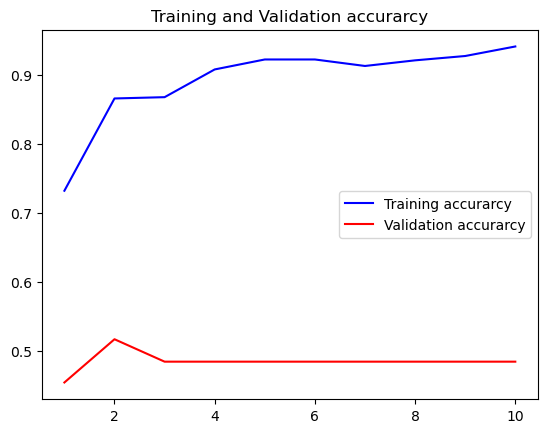

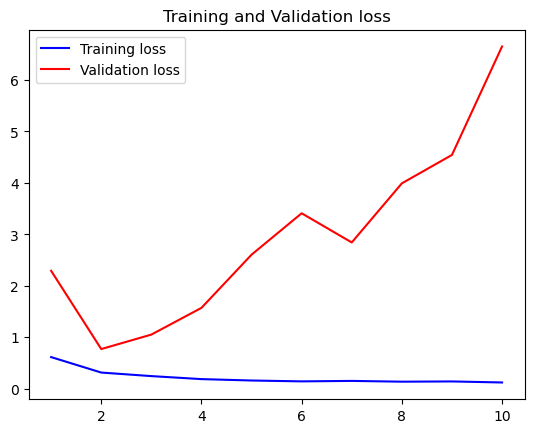

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
14/14 [==============================] - 12s 832ms/step - loss: 6.6528 - accuracy: 0.4849
Test Accuracy: 48.49188029766083


In [ ]:
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [ ]:
loaded_model = pickle.load(open('cnn_model.pkl', 'rb'))

AttributeError: 'Adam' object has no attribute 'build'

In [ ]:
loaded_model = pickle.load(open('path/cnn_model.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'path/cnn_model.pkl'

In [ ]:
print(x_test[25:26].shape)
print(y_test[25])

(1, 256, 256, 3)
[1 0 0]


In [ ]:
res = model.predict(x_test[25:26])

1/1 [==============================] - 1s 644ms/step


In [ ]:
print(res[0])

[0.01267524 0.94896376 0.03836106]


In [ ]:
#image_dir="PlantVillage/Potato/Potato___Early_blight/1a77c047-7ed8-4f02-bfaf-a19e7a67c3dd___RS_Early.B 7076.JPG"
#image_dir="PlantVillage/Potato/Potato___Late_blight/fff55a7e-2f86-4747-8d31-f1fde3c307aa___RS_LB 3081.JPG"
image_dir="PlantVillage/Potato/Potato___healthy/71c06efe-089f-49b3-beed-095bd7640e32___RS_HL 1947.JPG"

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [ ]:
im.shape

(256, 256, 3)

In [ ]:
result=model.predict(npp_image)

print(result)

1/1 [==============================] - 0s 80ms/step
[[0.0040111  0.8932658  0.10272316]]


In [ ]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.8932658
Potato___Late_blight
